In [2]:
import os
import librosa
from keras.models import Model, load_model
from keras.layers import Input, Activation, Concatenate, Permute, Reshape, Flatten, Lambda, Dot, Softmax, GRU, MaxPooling2D, Dropout
from keras.layers import Add, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D, Dense, LSTM, Bidirectional
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import optimizers
from keras.models import Sequential
from sklearn.utils import shuffle
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
import numpy as np
import matplotlib.pyplot as plt
import audiosegment as aud
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import IPython
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa
import time
from datetime import timedelta as td
import os
from librosa import display
import audiosegment

Using TensorFlow backend.
/home/anton/study_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/anton/study_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/anton/study_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/anton/study_env/lib/python3.6/si

In [3]:
def AttRNNSpeechModel(samplingrate = 16000, inputLength = 16000, rnn_func = LSTM):
    #simple LSTM
    sr = samplingrate
    iLen = inputLength
    
    inputs = Input((inputLength,), name='input')

    x = Reshape((1, -1)) (inputs)

    x = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                             padding='same', sr=sr, n_mels=80,
                             fmin=40.0, fmax=sr/2, power_melgram=1.0,
                             return_decibel_melgram=True, trainable_fb=False,
                             trainable_kernel=False,
                             name='mel_stft') (x)

    x = Normalization2D(int_axis=0)(x)

    #note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    #we would rather have it the other way around for LSTMs

    x = Permute((2,1,3)) (x)

    x = Conv2D(10, (5,1) , activation='relu', padding='same') (x)
    x = BatchNormalization() (x)
#     x = MaxPooling2D((5, 1))
#     x = Dropout(0.5)
    x = Conv2D(1, (5,1) , activation='relu', padding='same') (x)
    x = BatchNormalization() (x)
#     x = MaxPooling2D((5, 1))
#     x = Dropout(0.5)

    #x = Reshape((125, 80)) (x)
    x = Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim') (x) #keras.backend.squeeze(x, axis)

    x = Bidirectional(rnn_func(64, return_sequences = True, dropout=0.3)) (x) # [b_s, seq_len, vec_dim]
    x = Bidirectional(rnn_func(64, return_sequences = True, dropout=0.3)) (x) # [b_s, seq_len, vec_dim]
#     x = Bidirectional(rnn_func(64, return_sequences = True, dropout=0.3)) (x) # [b_s, seq_len, vec_dim]

    xFirst = Lambda(lambda q: q[:,64]) (x) #[b_s, vec_dim]
    query = Dense(128) (xFirst)

    #dot product attention
    attScores = Dot(axes=[1,2])([query, x]) 
    attScores = Softmax(name='attSoftmax')(attScores) #[b_s, seq_len]

    #rescale sequence
    attVector = Dot(axes=[1,1])([attScores, x]) #[b_s, vec_dim]

    x = Dense(64, activation = 'relu')(attVector)
    x = Dense(32)(x)

    output = Dense(1, activation = 'sigmoid', name='output')(x)

    model = Model(inputs=[inputs], outputs=[output])
    
    return model

In [4]:
def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

In [5]:
def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)

In [6]:
def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)

In [7]:
def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)

In [8]:
def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False,
):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose:
        start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
#         print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
#         print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
#     print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
#         print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
#         print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
#         print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
#     if verbose:
#         print("Signal recovery:", td(seconds=time.time() - start))
#     if visual:
#         plot_spectrogram(noise_stft_db, title="Noise")
#     if visual:
#         plot_statistics_and_filter(
#             mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
#         )
#     if visual:
#         plot_spectrogram(sig_stft_db, title="Signal")
#     if visual:
#         plot_spectrogram(sig_mask, title="Mask applied")
#     if visual:
#         plot_spectrogram(sig_stft_db_masked, title="Masked signal")
#     if visual:
#         plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal

In [9]:
data_path_0 = '/home/anton/Documents/final_set/0/'
data_path_1 = '/home/anton/Documents/final_set/1/'

In [10]:
X_train = []
y_train = []

In [11]:
list_0 = os.listdir(data_path_0)
list_1 = os.listdir(data_path_1)

In [12]:
for s in tqdm(list_0):
    y, sr = librosa.load(data_path_0 + s, sr=16000)
    X_train.append(removeNoise(audio_clip=y, noise_clip=y, n_std_thresh=2, prop_decrease=0.95, visual=True))
    y_train.append(0)

100%|██████████| 18086/18086 [15:23<00:00, 19.58it/s]


In [13]:
for s in tqdm(list_1):
    y, sr = librosa.load(data_path_1 + s, sr=16000)
    X_train.append(removeNoise(audio_clip=y, noise_clip=y, n_std_thresh=2, prop_decrease=0.95, visual=True))
    y_train.append(1)

100%|██████████| 10731/10731 [07:08<00:00, 25.05it/s]


In [14]:
X, y = shuffle(X_train, y_train, random_state=0)

In [18]:
X_test = X[25000:]
y_test = y[25000:]

In [19]:
model = AttRNNSpeechModel(samplingrate = 16000, inputLength = None)

tracking <tf.Variable 'mel_stft_1/real_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_real_kernels
tracking <tf.Variable 'mel_stft_1/imag_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_imag_kernels
tracking <tf.Variable 'mel_stft_1/Variable:0' shape=(513, 80) dtype=float32> freq2mel


In [20]:
earlystopper = EarlyStopping(monitor='accuracy', patience=5, verbose=1)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
results = model.fit(np.array(X[:25000]), np.array(y[:25000]), batch_size=64, validation_split=0.2, epochs = 20, callbacks=[earlystopper])

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 546s 27ms/step - loss: 0.3794 - acc: 0.8356 - val_loss: 0.6698 - val_acc: 0.6604
Epoch 2/20


/home/anton/study_env/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


20000/20000 [==============================] - 541s 27ms/step - loss: 0.2808 - acc: 0.8891 - val_loss: 0.2619 - val_acc: 0.8988
Epoch 3/20
20000/20000 [==============================] - 538s 27ms/step - loss: 0.2478 - acc: 0.9032 - val_loss: 0.2255 - val_acc: 0.9110
Epoch 4/20
20000/20000 [==============================] - 535s 27ms/step - loss: 0.2263 - acc: 0.9122 - val_loss: 0.1978 - val_acc: 0.9262
Epoch 5/20
20000/20000 [==============================] - 601s 30ms/step - loss: 0.2078 - acc: 0.9183 - val_loss: 0.2294 - val_acc: 0.9146
Epoch 6/20
20000/20000 [==============================] - 541s 27ms/step - loss: 0.2024 - acc: 0.9226 - val_loss: 0.2072 - val_acc: 0.9154
Epoch 7/20
20000/20000 [==============================] - 532s 27ms/step - loss: 0.1931 - acc: 0.9267 - val_loss: 0.1963 - val_acc: 0.9220
Epoch 8/20
20000/20000 [==============================] - 574s 29ms/step - loss: 0.1897 - acc: 0.9283 - val_loss: 0.1849 - val_acc: 0.9262
Epoch 9/20
20000/20000 [==============

In [21]:
names = []
borders = []
f = open('labels.txt')
lines = f.readlines()
for line in lines:
    line_list = line.split(' ')
    names.append(line_list[0])
    borders.append([line_list[1], line_list[2][:-1]])
border_dict = dict(zip(names, borders))
f.close()

In [22]:
new_names = []
new_borders = []
f = open('new_labels.txt')
lines = f.readlines()
for line in lines:
    line_list = line.split(' ')
    new_names.append(line_list[0])
    new_borders.append([line_list[1], line_list[2][:-1]])
new_border_dict = dict(zip(new_names, new_borders))
f.close()

In [23]:
test_0 = '/home/anton/Documents/test/0/'
test_1 = '/home/anton/Documents/test/1/'
new_test_0 = '/home/anton/Documents/new_test/0/'
new_test_1 = '/home/anton/Documents/new_test/1/'

In [24]:
test_sounds = []
test_labels = []
label_file = []
test_names = []

In [25]:
for s in os.listdir(test_0):
    test_sounds.append(aud.from_file(test_0 + s).resample(sample_rate_Hz=16000, sample_width=2, channels=1))
    test_labels.append(0)
    label_file.append('o')
    test_names.append(s)

In [26]:
for s in os.listdir(test_1):
    test_sounds.append(aud.from_file(test_1 + s).resample(sample_rate_Hz=16000, sample_width=2, channels=1))
    test_labels.append(1)
    label_file.append('o')
    test_names.append(s)

In [27]:
for s in os.listdir(new_test_0):
    test_sounds.append(aud.from_file(new_test_0 + s).resample(sample_rate_Hz=16000, sample_width=2, channels=1))
    test_labels.append(0)
    label_file.append('n')
    test_names.append(s)

In [28]:
for s in os.listdir(new_test_1):
    test_sounds.append(aud.from_file(new_test_1 + s).resample(sample_rate_Hz=16000, sample_width=2, channels=1))
    test_labels.append(1)
    label_file.append('n')
    test_names.append(s)

In [29]:
test_sounds, test_labels, label_file, test_names = shuffle(test_sounds, test_labels, label_file, test_names, random_state=0)

In [30]:
test_sounds = test_sounds[:100]

In [31]:
def audiosegment_to_ndarray(audiosegment):
    data = audiosegment.get_array_of_samples()
    data = librosa.util.buf_to_float(data,n_bytes=2,
                                      dtype=np.float32)
    if audiosegment.channels==2:
        sample_left= np.copy(data[::2])
        sample_right= np.copy(data[1::2])
        sample_all = np.array([sample_left,sample_right])
    else:
        sample_all = data
    data = removeNoise(audio_clip=sample_all, noise_clip=sample_all, n_std_thresh=2, prop_decrease=0.95, visual=True)
    return data

In [32]:
X_train[5].shape

(15872,)

In [33]:
audiosegment_to_ndarray(test_sounds[0][:1000]).shape

(15872,)

0
class - 1


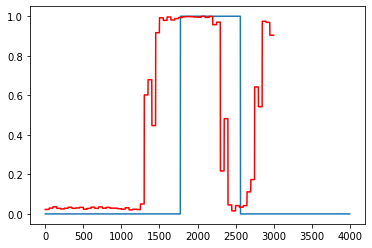

1
class - 1


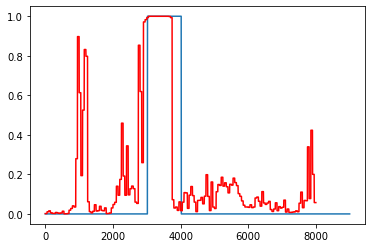

2
class - 1


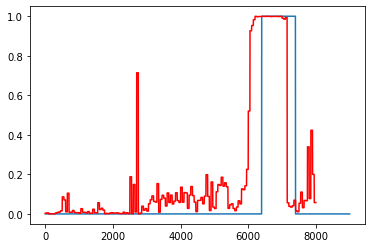

3
class - 0


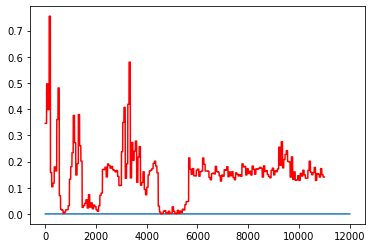

4
class - 0


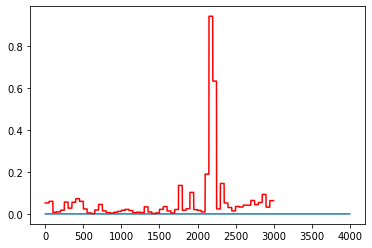

5
class - 1


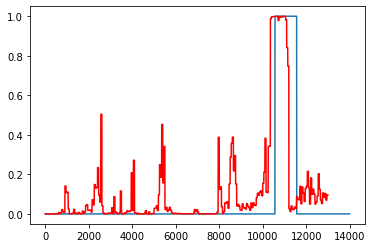

6
class - 0


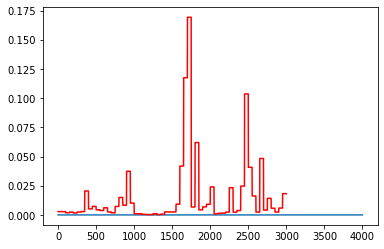

7
class - 0


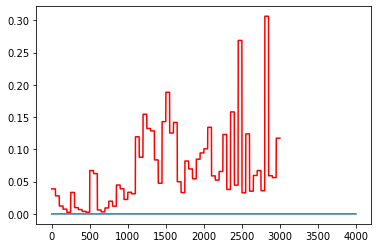

8
class - 1


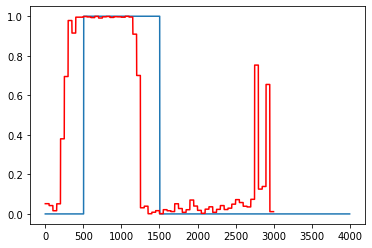

9
class - 1


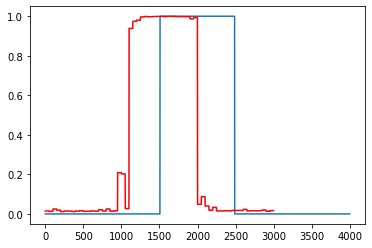

10
class - 1


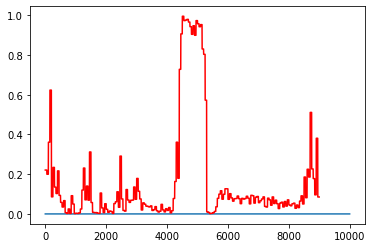

11
class - 0


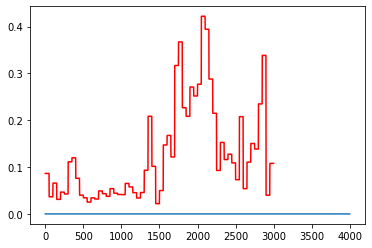

12
class - 0


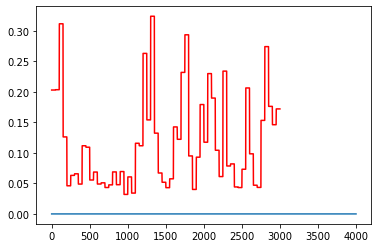

13
class - 1


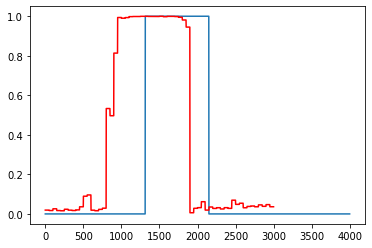

14
class - 1


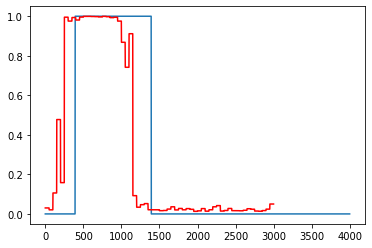

15
class - 1


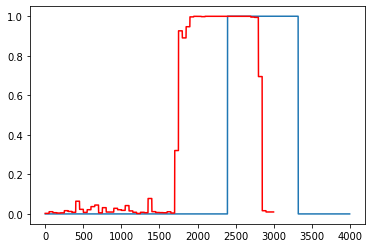

16
class - 0


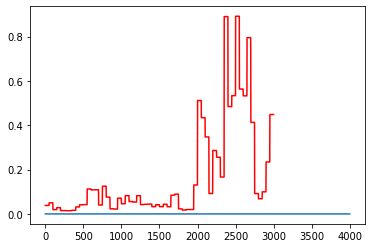

17
class - 0


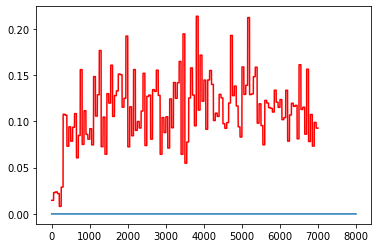

18
class - 1


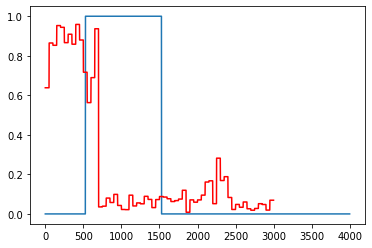

19
class - 0


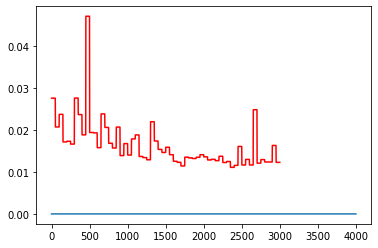

20
class - 0


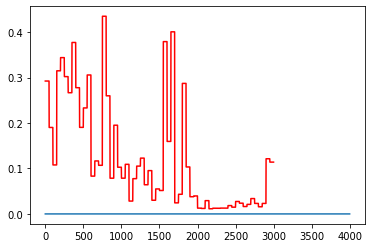

21
class - 0


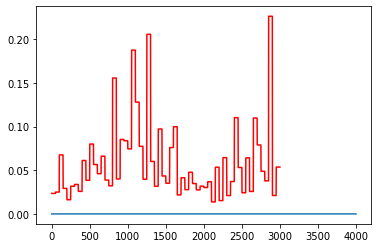

22
class - 0


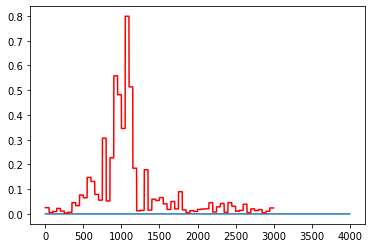

23
class - 0


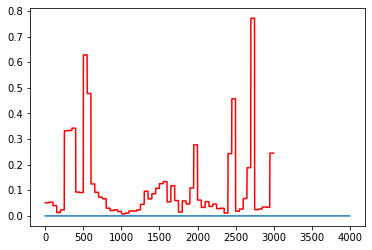

24
class - 0


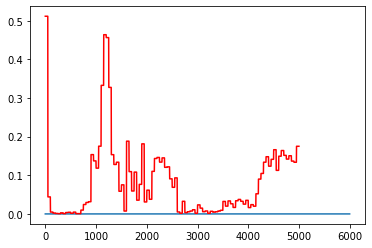

25
class - 1


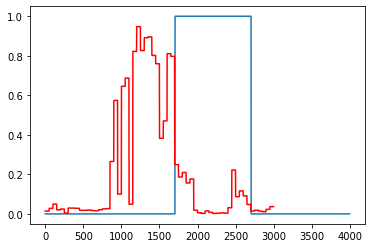

26
class - 1


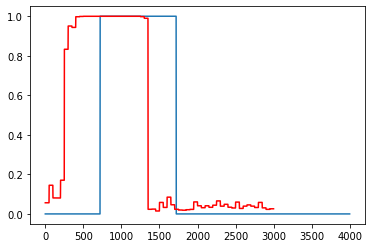

27
class - 1


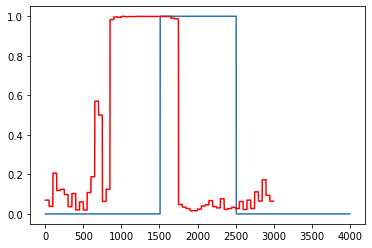

28
class - 0


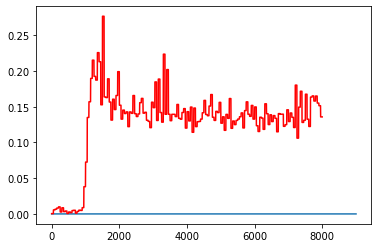

29
class - 1


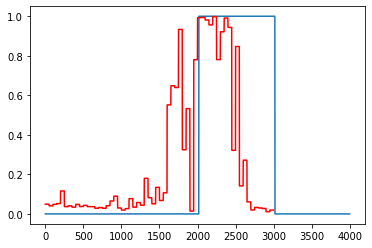

30
class - 1


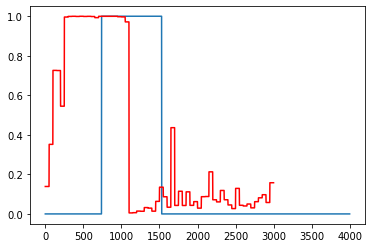

31
class - 1


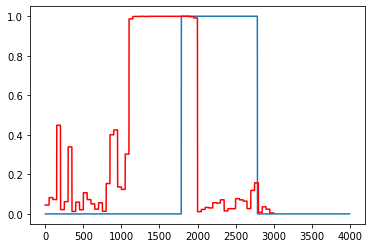

32
class - 1


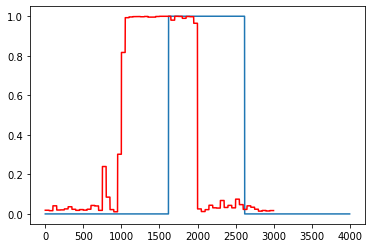

33
class - 0


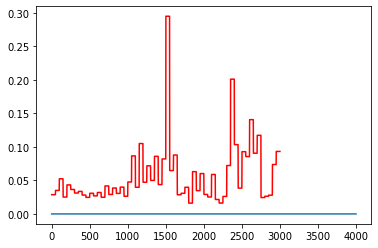

34
class - 1


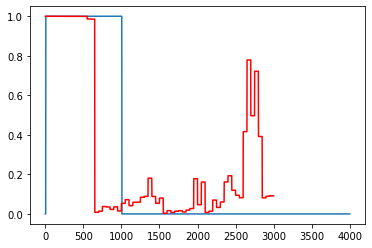

35
class - 0


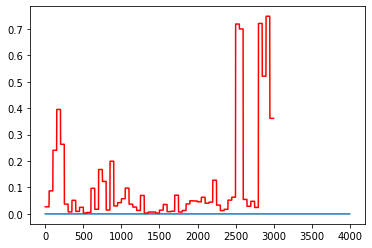

36
class - 1


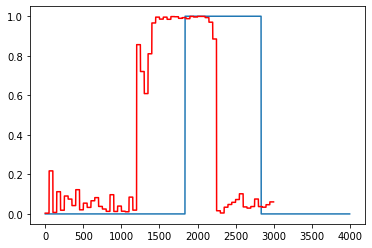

37
class - 0


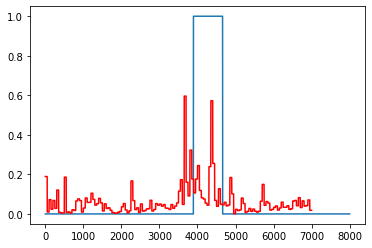

38
class - 0


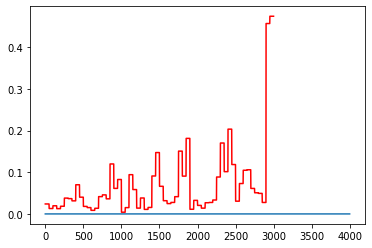

39
class - 0


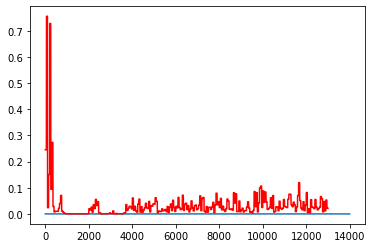

40
class - 1


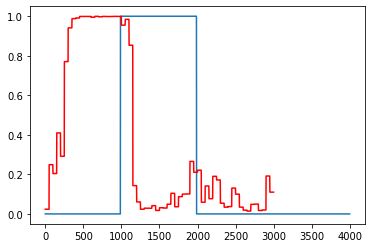

41
class - 0


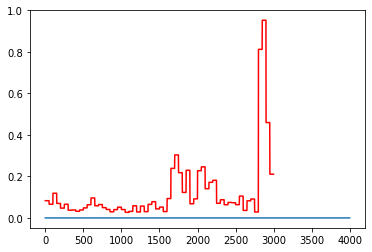

42
class - 0


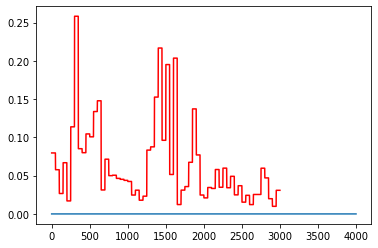

43
class - 1


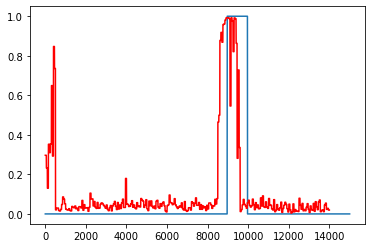

44
class - 0


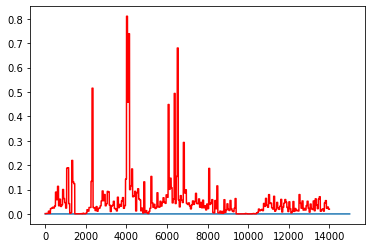

45
class - 1


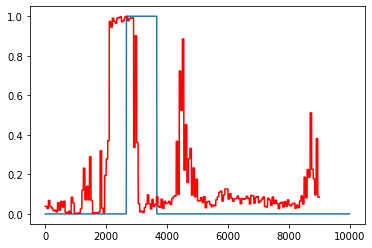

46
class - 0


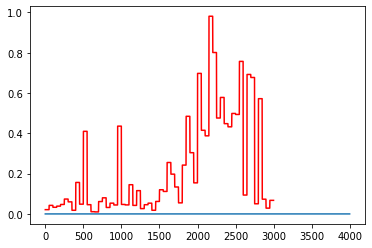

47
class - 0


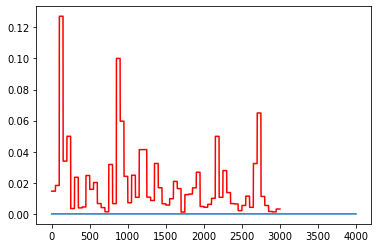

48
class - 0


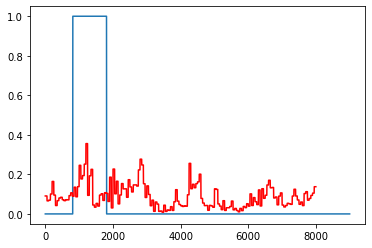

49
class - 1


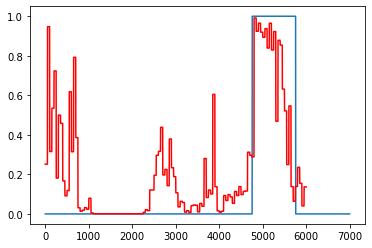

50
class - 1


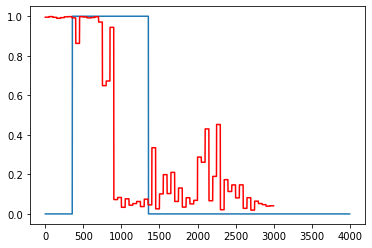

51
class - 1


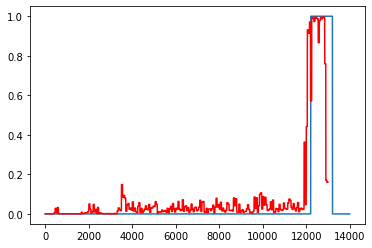

52
class - 1


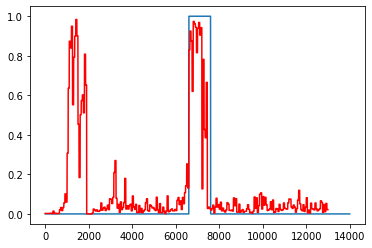

53
class - 1


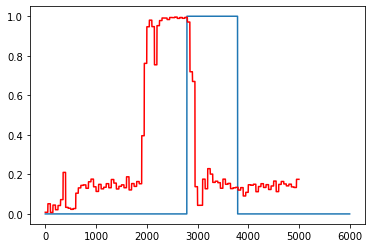

54
class - 1


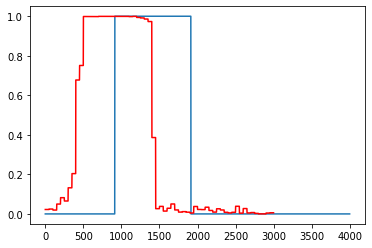

55
class - 0


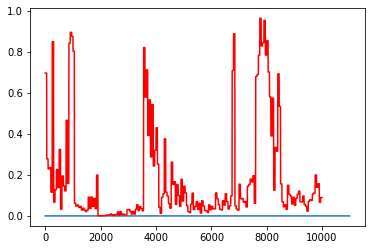

56
class - 0


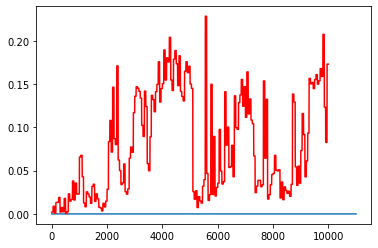

57
class - 0


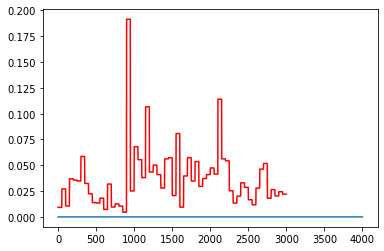

58
class - 1


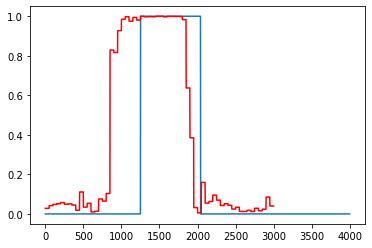

59
class - 0


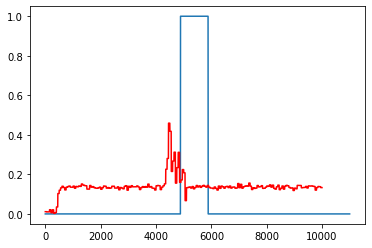

60
class - 1


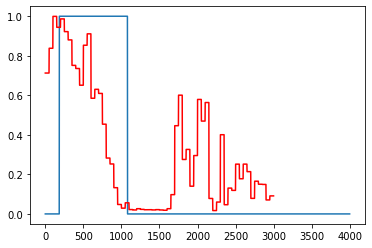

61
class - 1


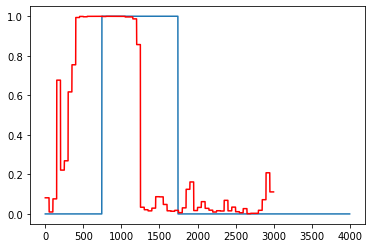

62
class - 1


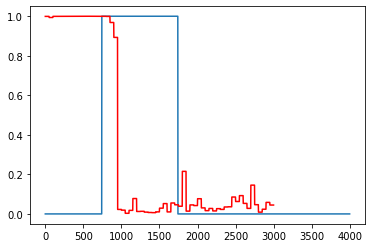

63
class - 0


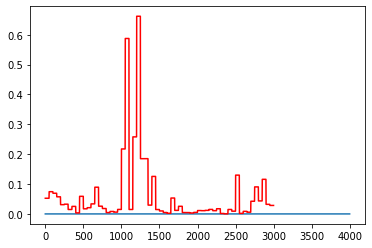

64
class - 1


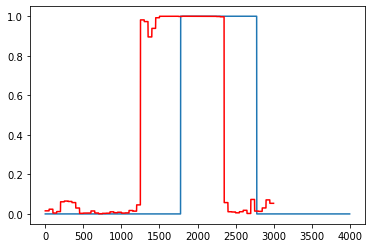

65
class - 0


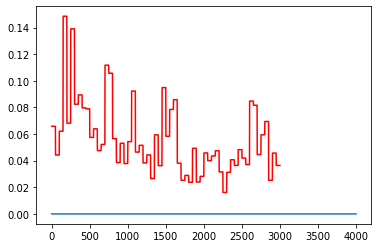

66
class - 1


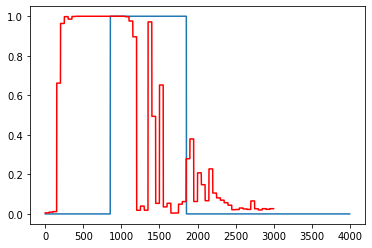

67
class - 0


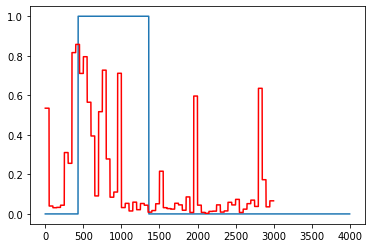

68
class - 0


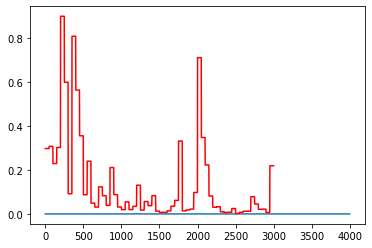

69
class - 0


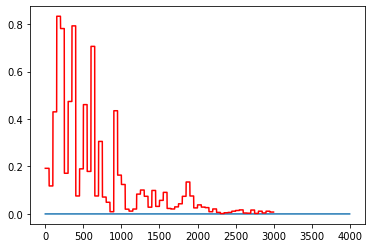

70
class - 1


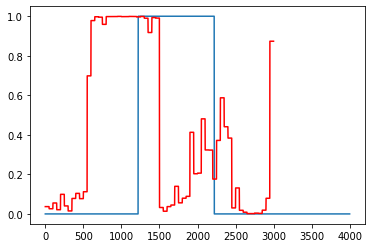

71
class - 0


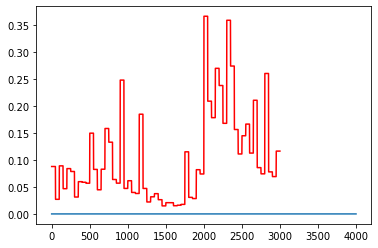

72
class - 1


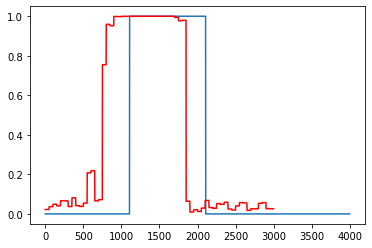

73
class - 0


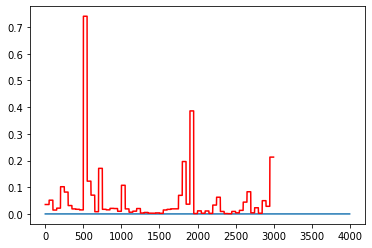

74
class - 1


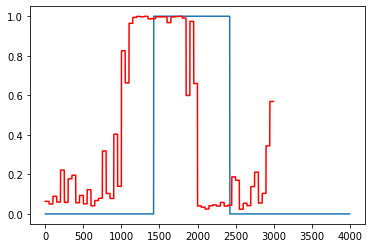

75
class - 1


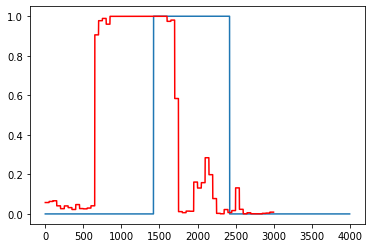

76
class - 0


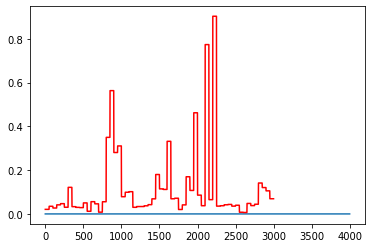

77
class - 0


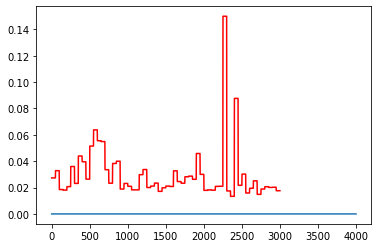

78
class - 0


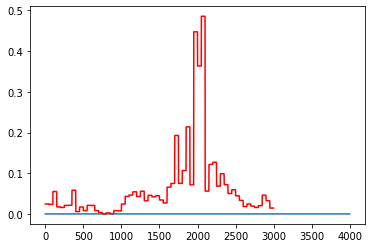

79
class - 1


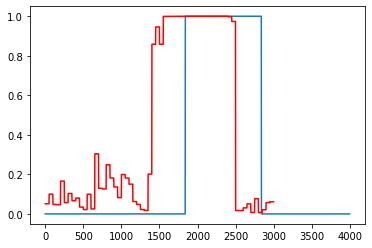

80
class - 1


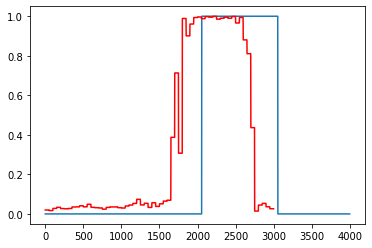

81
class - 1


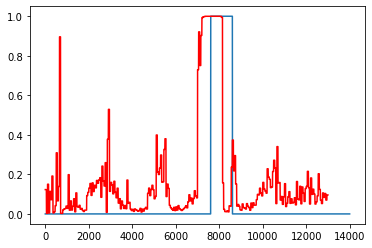

82
class - 1


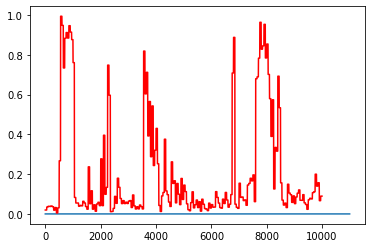

83
class - 0


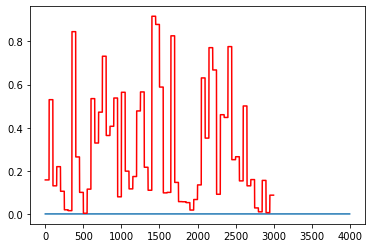

84
class - 1


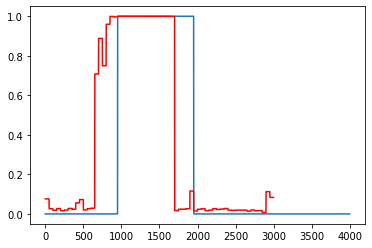

85
class - 0


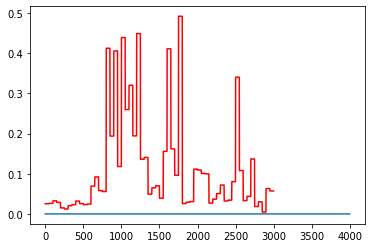

86
class - 0


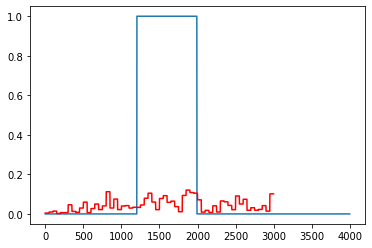

87
class - 0


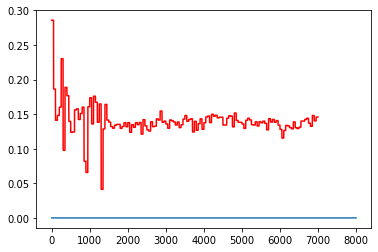

88
class - 1


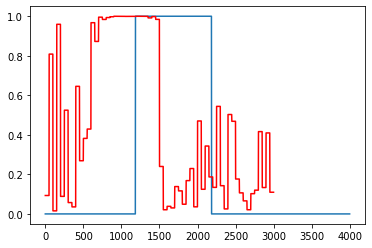

89
class - 1


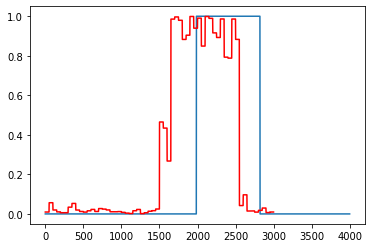

90
class - 1


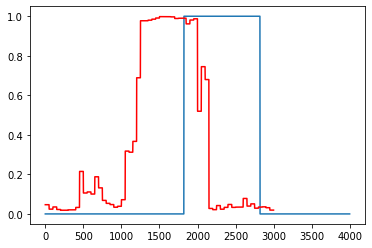

91
class - 1


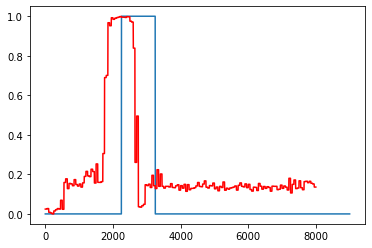

92
class - 0


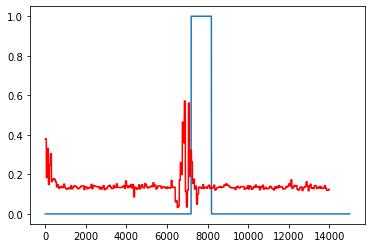

93
class - 0


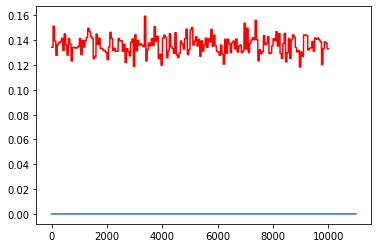

94
class - 1


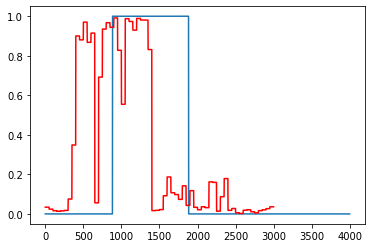

95
class - 1


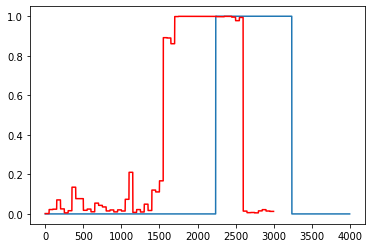

96
class - 1


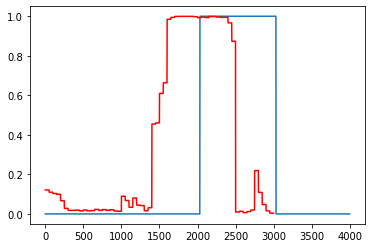

97
class - 0


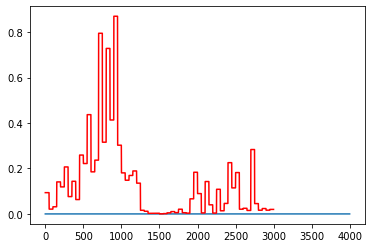

98
class - 0


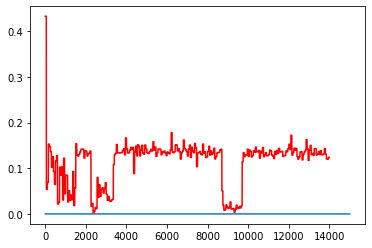

99
class - 1


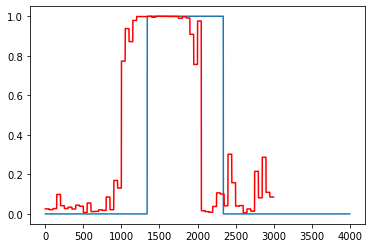

In [39]:
pr = []
for i, s in enumerate(test_sounds[:100]):
    real_values = []
    predicted_values = []
    p = 0
    if test_labels[i] == 0:
        real_values = [0 for k in range(len(s))]
        count = 0
        for j in range(0, len(s) - 1000, 50):
            aaa = audiosegment_to_ndarray(s[j:j+1000])
            aa = []
            aa.append(aaa)
            aa = np.array(aa)
            pr_val = model.predict(aa)[0]
            if pr_val > 0.8:
                count += 1
            else:
                count = 0
            if count >= 5:
                p += 1
            for _ in range(50):
                predicted_values.append(pr_val)
    else:
        start = 0
        end = 0
        if label_file[i] == 'o':
            start = border_dict[test_names[i]][0]
            end = border_dict[test_names[i]][1]
        else:
            start = new_border_dict[test_names[i]][0]
            end = new_border_dict[test_names[i]][1]
        real_values = [0 for k in range(len(s))]
        for k in range(int(start), int(end)):
            real_values[k] = 1
        for j in range(0, len(s) - 1000, 50):
            aaa = audiosegment_to_ndarray(s[j:j+1000])
            aa = []
            aa.append(aaa)
            aa = np.array(aa)
            pr_val = model.predict(aa)[0]
            if pr_val > 0.8:
                count += 1
            else:
                count = 0
            if count >= 5:
                p += 1
            for _ in range(50):
                predicted_values.append(pr_val)
    
    if p > 0:
        pr.append(1)
    else:
        pr.append(0)
    print(i)
    print('class - ' + str(pr[i]))
    plt.plot(real_values)
    plt.plot(predicted_values, color='red')
    plt.show()

In [40]:
accuracy_score(pr, test_labels[:100])

0.92

In [41]:
from sklearn.metrics import f1_score

In [42]:
f1_score(pr, test_labels[:100])

0.9259259259259259

In [43]:
model.save('2.h5')

In [44]:
model.save_weights('weights_2.h5')